# ATP13A2
[Kufor-Rakeb syndrome (KRS)](https://omim.org/entry/606693) and 
[autosomal recessive spastic paraplegia-78 (SPG78)](https://omim.org/entry/617225) are both
caused by homozygous or compound heterozygous mutation in the ATP13A2 gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


### ATP13A2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ATP13A2.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'ATP13A2'
mane_tx_id = 'NM_022089.4'
mane_protein_id = 'NP_071372.1' # polyamine-transporting ATPase 13A2 isoform 1"
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.24') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 45/45 [00:00<00:00, 1275.66 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
34,Bradykinesia
31,Parkinsonism
29,Babinski sign
28,Dementia
27,Rigidity
26,Hyperreflexia
23,Dysarthria
19,Supranuclear gaze palsy
17,Slow saccadic eye movements
14,Mask-like facies


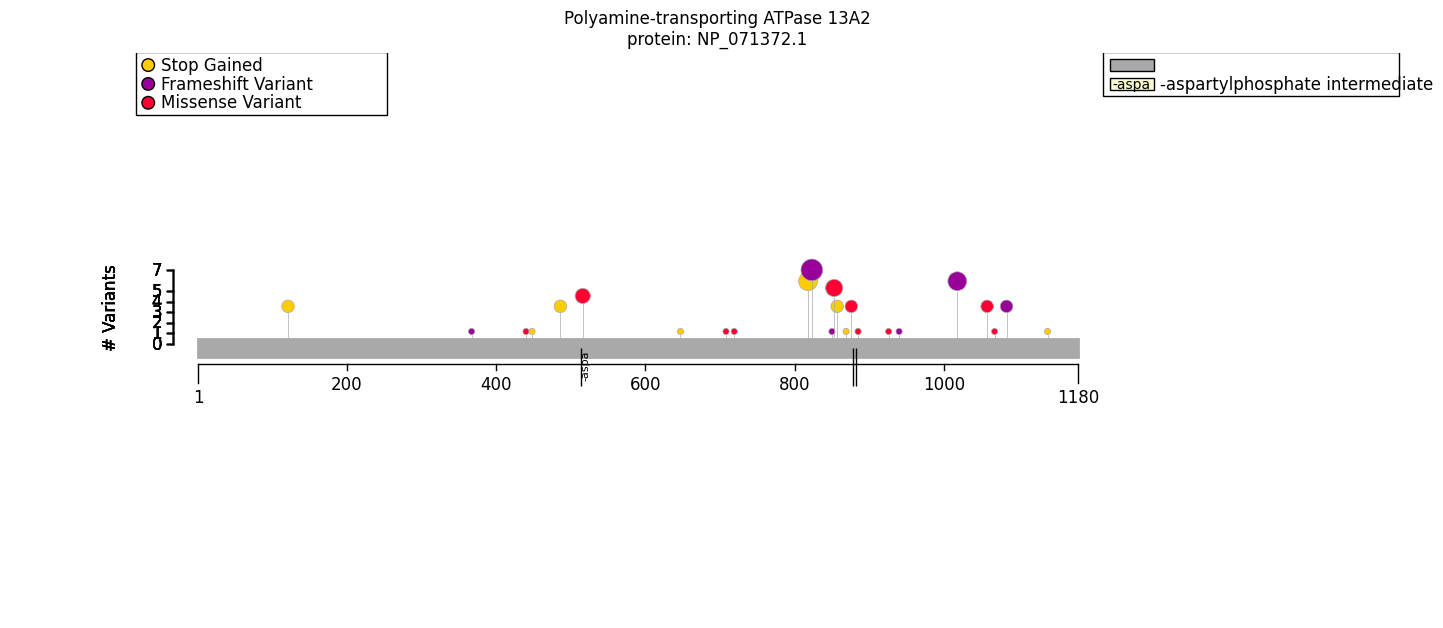

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

atp13a2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
atp13a2_fig.tight_layout()

## Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = biallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense, 
    partitions=((0,1), (2,)), 
    a_label="missense", 
    b_label="other")

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,10
HMF03,Skipping term because of a child term with the same individual counts,3
HMF08,Skipping general term,40
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,128


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense/missense OR missense/other,other/other,Corrected p values,p values
Supranuclear gaze palsy [HP:0000605],3/7 (43%),16/19 (84%),1.0,0.057221
Bradykinesia [HP:0002067],11/16 (69%),23/26 (88%),1.0,0.223305
Slow saccadic eye movements [HP:0000514],4/8 (50%),13/18 (72%),1.0,0.382101
Tremor [HP:0001337],4/11 (36%),11/21 (52%),1.0,0.471914
Babinski sign [HP:0003487],10/11 (91%),19/24 (79%),1.0,0.639943
Dementia [HP:0000726],10/14 (71%),18/22 (82%),1.0,0.683230
Parkinsonism [HP:0001300],12/16 (75%),19/23 (83%),1.0,0.693721
Visual hallucination [HP:0002367],1/3 (33%),9/22 (41%),1.0,1.000000
Dysarthria [HP:0001260],10/10 (100%),13/14 (93%),1.0,1.000000
Mental deterioration [HP:0001268],10/10 (100%),18/18 (100%),1.0,1.000000


In [9]:
from gpsea.analysis.clf import diagnosis_classifier

krs_id = "OMIM:606693" # Kufor-Rakeb syndrome
sp78_id = "OMIM:617225" # Spastic paraplegia 78, autosomal recessive

disease_clf = diagnosis_classifier(
    diagnoses=(krs_id, sp78_id),
    labels=('Kufor-Rakeb syndrome', 'Spastic paraplegia 78, autosomal recessive'),
)

dx_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=disease_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=dx_result)

Diagnosis,OMIM:606693,OMIM:617225,Corrected p values,p values
Parkinsonism [HP:0001300],28/28 (100%),3/11 (27%),0.000072,0.000003
Bradykinesia [HP:0002067],30/32 (94%),4/10 (40%),0.012358,0.000915
Slow saccadic eye movements [HP:0000514],15/18 (83%),2/8 (25%),0.069389,0.007710
Dementia [HP:0000726],24/27 (89%),4/9 (44%),0.089006,0.013186
Supranuclear gaze palsy [HP:0000605],17/20 (85%),2/6 (33%),0.149900,0.027759
Dystonia [HP:0001332],11/18 (61%),1/6 (17%),0.686358,0.154953
Tremor [HP:0001337],14/26 (54%),1/6 (17%),0.686358,0.177945
Dysarthria [HP:0001260],14/14 (100%),9/10 (90%),1.000000,0.416667
Babinski sign [HP:0003487],19/24 (79%),10/11 (91%),1.000000,0.639943
Atrophy/Degeneration affecting the central nervous system [HP:0007367],10/10 (100%),8/8 (100%),1.000000,1.000000


# Summary

In [10]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ), GPAnalysisResultSummary.from_multi(
        result=dx_result,
    ),
)

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [11]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [12]:
summarizer.process_latex(report=report, protein_fig=atp13a2_fig)

Figure saved to ../../supplement/img/ATP13A2_protein_diagram-draft.pdf
Output to ../../supplement/tex/ATP13A2_summary_draft.tex
